# **Importación de bibliotecas**

In [ ]:
"""
Este notebook utiliza diversas librerías que permiten realizar tareas de cálculo numérico,
procesamiento de datos, análisis de audio, visualización y manipulación de imágenes, además de
integrarse con Google Drive. A continuación se describen brevemente cada uno de los módulos importados:

- torch: Biblioteca para computación numérica avanzada y operaciones con tensores, optimizada para GPU.
- numpy: Librería fundamental para computación científica en Python, especialmente en operaciones
         con arreglos multidimensionales.
- unittest: Módulo estándar de Python para la creación y ejecución de pruebas unitarias.
- scipy.io.wavfile: Funciones para leer y escribir archivos de audio en formato WAV.
- matplotlib.pyplot: Módulo para la generación de gráficos y visualizaciones de datos.
- google.colab.drive: Permite montar y acceder a Google Drive directamente desde el entorno de Colab.
- PIL.Image: Parte de la librería Pillow para abrir, manipular y guardar imágenes.
"""

import torch  # PyTorch: operaciones tensoriales y cálculos optimizados para GPU
import numpy as np  # NumPy: soporte para arrays y operaciones matemáticas de alto rendimiento
import unittest  # Unittest: framework para realizar pruebas unitarias
from scipy.io import wavfile  # Funciones para manejo de archivos WAV (lectura y escritura de audio)
import matplotlib.pyplot as plt  # Matplotlib: creación de gráficos y visualizaciones
from google.colab import drive  # Integración con Google Drive para acceder a archivos almacenados en la nube
from PIL import Image  # Pillow: manipulación y procesamiento de imágenes


# **Importación de datos**

In [ ]:
drive.mount('/content/drive', force_remount=True)

C4_02_1_1_DAPI_001_bmp = '/content/drive/MyDrive/TP1/input/C4_02_1_1_DAPI_001.bmp'
C4_02_1_1_DAPI_001_tif = '/content/drive/MyDrive/TP1/input/C4_02_1_1_DAPI_001.tif'
contaminated_audio = '/content/drive/MyDrive/TP1/input/contaminated_audio.wav'
cuadro1_005 = '/content/drive/MyDrive/TP1/input/cuadro1_005.bmp'
manu = '/content/drive/MyDrive/TP1/input/manu.jpg'
trackedCell15 = '/content/drive/MyDrive/TP1/input/trackedCell15.tif'

Mounted at /content/drive


In [ ]:
def charge_image(image_url: str) -> torch.Tensor:
    """
    Carga una imagen desde una ruta o URL, la convierte a escala de grises y la transforma en un tensor de PyTorch.

    La función realiza los siguientes pasos:
      1. Abre la imagen usando la librería PIL a partir de la ruta o URL especificada.
      2. Convierte la imagen a escala de grises mediante el método 'convert("L")'.
      3. Transforma la imagen en un array de NumPy.
      4. Convierte el array de NumPy en un tensor de PyTorch con tipo float32.

    Parámetros:
    -----------
    image_url : str
        Ruta o URL de la imagen a cargar.

    Retorna:
    --------
    torch.Tensor
        Tensor que representa la imagen en escala de grises.

    Notas:
    ------
    - Se asume que la imagen se encuentra en una ubicación accesible y que puede ser abierta con PIL.
    - En caso de error al cargar la imagen, se genera una excepción con un mensaje descriptivo.
    """
    try:
        # Abrir la imagen utilizando la ruta o URL proporcionada y convertirla a escala de grises.
        imagen_pil = Image.open(image_url).convert("L")
    except Exception as e:
        # En caso de fallo, lanzar una excepción con información del error.
        raise ValueError(f"No se pudo cargar la imagen desde {image_url}. Error: {e}")

    # Convertir la imagen PIL a un array de NumPy.
    imagen_np = np.array(imagen_pil)

    # Convertir el array de NumPy en un tensor de PyTorch de tipo float32.
    imagen_tensor = torch.tensor(imagen_np, dtype=torch.float32)

    return imagen_tensor

# **Implementación del algoritmo de Kittler**

**Algoritmo de Kittler:**

El algoritmo de Kittler, también conocido como Minimum Error Thresholding, se utiliza en el procesamiento de imágenes para segmentar una imagen en dos clases (por ejemplo, fondo y objeto) asumiendo que ambas clases pueden modelarse mediante distribuciones gaussianas.

Propósito:
Determinar el umbral óptimo que minimice el error de clasificación, es decir, que reduzca la probabilidad de mal clasificar los píxeles entre fondo y objeto.

Cómo Funciona:

Se calcula el histograma de la imagen y se normaliza para obtener la función de densidad de probabilidad (p).

Para cada posible umbral candidato (T), se separa la imagen en dos grupos:

Fondo: píxeles con intensidades ≤ T.

Objeto: píxeles con intensidades > T.

Se calculan los momentos estadísticos de cada grupo: probabilidad (ω), media (μ) y varianza (σ²).

Con estos parámetros, se evalúa una función de coste basada en la suposición de modelos gaussianos para ambos grupos.

El umbral que minimiza este coste se considera el óptimo para la segmentación.

Aplicación en Procesamiento de Imágenes:
Este método se aplica en tareas de segmentación donde se requiere separar el fondo del objeto, como en análisis médico, reconocimiento de patrones o en la preparación de imágenes para análisis posteriores.

## 1.
Implemente el algoritmo de Kittler, y realice una prueba con la imagen de entrada provista, aplicando posteriormente el umbral óptimo obtenido.

### **a.**

In [ ]:
def calcular_momentos_estadisticos(T: int, p: torch.Tensor) -> dict:
    """
    Calcula los momentos estadísticos (probabilidad, media y varianza) para dos clases
    separadas por un umbral T en una función de densidad de probabilidad.

    La función asume que 'p' es un tensor de PyTorch de 1D que contiene la densidad de
    probabilidad normalizada de los niveles de intensidad de una imagen, es decir, cada
    posición en 'p' representa la probabilidad de ocurrencia de la intensidad correspondiente.

    Se divide la función de densidad en dos grupos:
        - Grupo fondo: niveles de intensidad desde 0 hasta T (inclusive).
        - Grupo objeto: niveles de intensidad desde T+1 hasta el final.

    Para cada grupo se calculan:
        - omega: suma de probabilidades (indicador de la masa total del grupo).
        - mu: media ponderada de las intensidades.
        - sigma: varianza ponderada de las intensidades.

    Parámetros:
    -----------
    T : int
        Valor de umbral candidato que separa los dos grupos. Representa un índice de intensidad.
    p : torch.Tensor
        Tensor 1D normalizado que contiene la probabilidad de cada nivel de intensidad.

    Retorna:
    --------
    dict
        Diccionario con los siguientes parámetros:
            - 'omega0': Probabilidad total del grupo fondo (niveles 0 a T).
            - 'omega1': Probabilidad total del grupo objeto (niveles T+1 a L-1).
            - 'mu0': Media del grupo fondo.
            - 'mu1': Media del grupo objeto.
            - 'sigma0': Varianza del grupo fondo.
            - 'sigma1': Varianza del grupo objeto.
    """

    # Crear un vector con los índices de intensidad (0, 1, ..., L-1)
    niveles = torch.arange(len(p), dtype=torch.float32)

    # --- Cálculo para el grupo de fondo ---
    # Si T es menor a 0, se asume que no existe grupo de fondo y se asignan ceros.
    if T < 0:
        omega0 = torch.tensor(0.0)
        mu0 = torch.tensor(0.0)
        sigma0 = torch.tensor(0.0)
    else:
        # Seleccionar los valores de la función de densidad para intensidades de 0 a T.
        p_fondo = p[:T+1]
        # Seleccionar los niveles de intensidad correspondientes.
        niveles_fondo = niveles[:T+1]
        # Calcular la probabilidad total (masa) del fondo.
        omega0 = torch.sum(p_fondo)
        if omega0 > 0:
            # Calcular la media del fondo: suma de (intensidad * probabilidad) dividida entre la masa.
            mu0 = torch.sum(niveles_fondo * p_fondo) / omega0
            # Calcular la varianza del fondo: suma ponderada de las diferencias al cuadrado respecto a la media.
            sigma0 = torch.sum(p_fondo * (niveles_fondo - mu0)**2) / omega0
        else:
            # En caso de que omega0 sea 0, se asignan ceros a media y varianza.
            mu0 = torch.tensor(0.0)
            sigma0 = torch.tensor(0.0)

    # --- Cálculo para el grupo de objeto ---
    # Si T es mayor o igual al último índice, se considera que no hay grupo de objeto.
    if T >= len(p) - 1:
        omega1 = torch.tensor(0.0)
        mu1 = torch.tensor(0.0)
        sigma1 = torch.tensor(0.0)
    else:
        # Seleccionar los valores de la función de densidad para intensidades de T+1 al final.
        p_objeto = p[T+1:]
        # Seleccionar los niveles de intensidad correspondientes.
        niveles_objeto = niveles[T+1:]
        # Calcular la probabilidad total (masa) del objeto.
        omega1 = torch.sum(p_objeto)
        if omega1 > 0:
            # Calcular la media del objeto.
            mu1 = torch.sum(niveles_objeto * p_objeto) / omega1
            # Calcular la varianza del objeto.
            sigma1 = torch.sum(p_objeto * (niveles_objeto - mu1)**2) / omega1
        else:
            # En caso de que omega1 sea 0, se asignan ceros a media y varianza.
            mu1 = torch.tensor(0.0)
            sigma1 = torch.tensor(0.0)

    # Convertir los tensores escalares a valores numéricos utilizando .item() y retornar en un diccionario.
    return {
        'omega0': omega0.item(),  # Probabilidad total del fondo.
        'omega1': omega1.item(),  # Probabilidad total del objeto.
        'mu0': mu0.item(),        # Media del fondo.
        'mu1': mu1.item(),        # Media del objeto.
        'sigma0': sigma0.item(),  # Varianza del fondo.
        'sigma1': sigma1.item()   # Varianza del objeto.
    }


#### a.1.

In [ ]:
class TestCalcularMomentosEstadisticos(unittest.TestCase):
    def setUp(self):
        """
        Método de configuración que se ejecuta antes de cada prueba.
        Se crea un histograma uniforme de 256 niveles, que se normaliza para que la suma sea 1.
        Este histograma se utilizará en todas las pruebas para asegurar consistencia.
        """
        self.num_bins = 256
        # Crear un histograma uniforme: cada nivel tiene la misma probabilidad.
        self.p_uniforme = torch.ones(self.num_bins, dtype=torch.float32)
        self.p_uniforme = self.p_uniforme / torch.sum(self.p_uniforme)

    def test_histograma_uniforme(self):
        """
        Prueba con un histograma uniforme:
        - Se utiliza un umbral T = 127, por lo que se espera que:
            • El grupo fondo contenga 128 valores (0 a 127) y el objeto los restantes (128 a 255).
            • Las probabilidades (omega0 y omega1) sean 0.5 cada una.
            • La media y varianza se calculen teóricamente para una distribución uniforme en esos rangos.
        """
        T = 127
        resultados = calcular_momentos_estadisticos(T, self.p_uniforme)
        print("resultado test_histograma_uniforme: ", resultados)

        # Probabilidades esperadas: fondo y objeto con 128 valores cada uno.
        omega0_esperado = 128 / 256  # 0.5
        omega1_esperado = 128 / 256  # 0.5

        # Media esperada para el fondo: promedio de 0 a 127.
        mu0_esperado = (0 + 127) / 2  # 63.5
        # Media esperada para el objeto: promedio de 128 a 255.
        mu1_esperado = (128 + 255) / 2  # 191.5

        # Varianza para una distribución uniforme discreta:
        # Fórmula: ((n^2 - 1) / 12), donde n es el número de valores.
        sigma0_esperado = (128**2 - 1) / 12  # Aproximadamente 1365.25
        sigma1_esperado = sigma0_esperado       # Misma varianza para ambos grupos uniformes

        # Comprobación de las probabilidades (omega)
        self.assertAlmostEqual(resultados['omega0'], omega0_esperado, places=3)
        self.assertAlmostEqual(resultados['omega1'], omega1_esperado, places=3)
        # Comprobación de las medias (mu)
        self.assertAlmostEqual(resultados['mu0'], mu0_esperado, places=3)
        self.assertAlmostEqual(resultados['mu1'], mu1_esperado, places=3)
        # Comprobación de las varianzas (sigma)
        self.assertAlmostEqual(resultados['sigma0'], sigma0_esperado, places=3)
        self.assertAlmostEqual(resultados['sigma1'], sigma1_esperado, places=3)

    def test_todo_en_fondo(self):
        """
        Prueba donde el umbral T es igual al máximo índice (T = 255):
        - Se espera que todo el histograma se considere fondo.
        - La probabilidad del fondo (omega0) debe ser 1, y la del objeto (omega1) 0.
        - La media y varianza se calculan sobre el rango completo [0, 255].
        """
        T = 255  # Todo se considera fondo
        resultados = calcular_momentos_estadisticos(T, self.p_uniforme)
        print("resultado test_todo_en_fondo: ", resultados)

        # Probabilidades esperadas
        omega0_esperado = 1.0
        omega1_esperado = 0.0

        # Cálculo teórico para una distribución uniforme en [0, 255]
        mu0_esperado = (0 + 255) / 2  # 127.5
        sigma0_esperado = ((256**2 - 1) / 12)  # Aproximadamente 5461.25

        self.assertAlmostEqual(resultados['omega0'], omega0_esperado, places=3)
        self.assertAlmostEqual(resultados['omega1'], omega1_esperado, places=3)
        self.assertAlmostEqual(resultados['mu0'], mu0_esperado, places=3)
        self.assertAlmostEqual(resultados['sigma0'], sigma0_esperado, places=3)
        # Para el grupo objeto se esperan ceros
        self.assertAlmostEqual(resultados['mu1'], 0.0, places=3)
        self.assertAlmostEqual(resultados['sigma1'], 0.0, places=3)

    def test_todo_en_objeto(self):
        """
        Prueba donde el umbral T es menor que el mínimo (T = -1):
        - Se espera que no haya fondo, es decir, que todo el histograma se considere objeto.
        - La probabilidad del fondo (omega0) debe ser 0, y la del objeto (omega1) 1.
        - La media y varianza se calculan sobre el rango completo [0, 255] para el objeto.
        """
        T = -1  # No hay fondo, todo se considera objeto
        resultados = calcular_momentos_estadisticos(T, self.p_uniforme)
        print("resultado test_todo_en_objeto: ", resultados)

        # Probabilidades esperadas
        omega0_esperado = 0.0
        omega1_esperado = 1.0

        # Cálculo teórico para una distribución uniforme en [0, 255] para el grupo objeto.
        mu1_esperado = (0 + 255) / 2  # 127.5
        sigma1_esperado = ((256**2 - 1) / 12)  # Aproximadamente 5461.25

        self.assertAlmostEqual(resultados['omega0'], omega0_esperado, places=3)
        self.assertAlmostEqual(resultados['omega1'], omega1_esperado, places=3)
        # Para el fondo se esperan ceros
        self.assertAlmostEqual(resultados['mu0'], 0.0, places=3)
        self.assertAlmostEqual(resultados['sigma0'], 0.0, places=3)
        # Comprobación para el grupo objeto
        self.assertAlmostEqual(resultados['mu1'], mu1_esperado, places=3)
        self.assertAlmostEqual(resultados['sigma1'], sigma1_esperado, places=3)


# Ejecutar las pruebas unitarias
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


......
----------------------------------------------------------------------
Ran 6 tests in 0.012s

OK


Costo para histograma delta y T=50: -26.631023115927547
Costo para histograma delta y T=150: -26.631023115927547
Costo para histograma uniforme y T=255: 18.210863960898507
Costo para histograma uniforme y T=127: 16.824476044653352
resultado test_histograma_uniforme:  {'omega0': 0.5, 'omega1': 0.5, 'mu0': 63.5, 'mu1': 191.5, 'sigma0': 1365.25, 'sigma1': 1365.25}
resultado test_todo_en_fondo:  {'omega0': 1.0, 'omega1': 0.0, 'mu0': 127.5, 'mu1': 0.0, 'sigma0': 5461.25, 'sigma1': 0.0}
resultado test_todo_en_objeto:  {'omega0': 0.0, 'omega1': 1.0, 'mu0': 0.0, 'mu1': 127.5, 'sigma0': 0.0, 'sigma1': 5461.25}


In [ ]:
def calcular_histograma_normalizado(imagen: torch.Tensor, num_bins: int = 256) -> tuple:
    """
    Calcula el histograma normalizado de una imagen en escala de grises.

    La función asume que la imagen ya está cargada como un tensor de PyTorch en escala de grises.
    Realiza los siguientes pasos:
      1. Aplana el tensor de la imagen para obtener un vector unidimensional de píxeles.
      2. Convierte el vector de píxeles a un array de NumPy para utilizar la función np.histogram.
      3. Calcula el histograma de la imagen, utilizando el número de bins especificado y el rango [0, num_bins].
      4. Convierte el histograma resultante a un tensor de PyTorch (tipo float32).
      5. Normaliza el histograma dividiendo cada valor por la suma total de los elementos, de modo que la suma de las frecuencias sea 1.

    Parámetros:
    -----------
    imagen : torch.Tensor
        Tensor que representa la imagen en escala de grises. Se espera que las intensidades estén en el rango [0, 255].
    num_bins : int, opcional
        Número de bins (niveles de intensidad) para calcular el histograma. Por defecto es 256, lo que es
        adecuado para imágenes con intensidades en el rango [0, 255].

    Retorna:
    --------
    tuple
        Una tupla que contiene:
          - hist_normalizado (torch.Tensor): Tensor 1D con el histograma normalizado, donde cada elemento
            representa la frecuencia relativa de píxeles en el rango correspondiente.
          - bin_edges (np.ndarray): Array de NumPy con los bordes de los bins utilizados en el histograma.
    """
    # Aplanar la imagen para obtener un vector unidimensional con todos los píxeles.
    pixels = imagen.flatten()

    # Convertir el tensor de píxeles a un array de NumPy para utilizar la función np.histogram.
    pixels_np = pixels.numpy()

    # Calcular el histograma de la imagen.
    # Se especifica el número de bins y el rango de intensidades (0 a num_bins).
    hist, bin_edges = np.histogram(pixels_np, bins=num_bins, range=(0, num_bins))

    # Convertir el histograma a un tensor de PyTorch con tipo float32.
    hist_tensor = torch.tensor(hist, dtype=torch.float32)

    # Normalizar el histograma para que la suma de sus elementos sea 1.
    hist_normalizado = hist_tensor / torch.sum(hist_tensor)

    return hist_normalizado, bin_edges


### b.

In [ ]:
def calcular_costo_J(T: int, p: torch.Tensor) -> float:
    """
    Calcula el costo J para un umbral candidato T usando la formulación del algoritmo de Kittler.

    El costo se define mediante la siguiente expresión:

        J(T) = 1 + 2*(ω₀ * log(σ₀ + ε) + ω₁ * log(σ₁ + ε)) - 2*(ω₀ * log(ω₀ + ε) + ω₁ * log(ω₁ + ε))

    donde:
      - ω₀ y ω₁ son las probabilidades (pesos) de las clases de fondo y objeto, respectivamente.
      - σ₀ y σ₁ son las varianzas de cada clase.
      - ε es un valor pequeño para evitar problemas al calcular el logaritmo de cero.

    Estos parámetros se obtienen a partir de la función de densidad de probabilidad `p` y del umbral `T`,
    mediante la función `calcular_momentos_estadisticos`.

    Parámetros:
    -----------
    T : int
        Umbral candidato para segmentar la imagen.
    p : torch.Tensor
        Tensor 1D que representa el histograma normalizado (función de densidad) de los niveles de intensidad.

    Retorna:
    --------
    float
        Valor del costo J para el umbral T.
    """
    # Obtener los momentos estadísticos para el umbral T mediante la función auxiliar.
    # Se espera que 'momentos' sea un diccionario con las claves:
    #   'omega0', 'omega1', 'sigma0' y 'sigma1'
    momentos = calcular_momentos_estadisticos(T, p)
    omega0 = momentos['omega0']  # Probabilidad total del grupo fondo.
    omega1 = momentos['omega1']  # Probabilidad total del grupo objeto.
    sigma0 = momentos['sigma0']  # Varianza del grupo fondo.
    sigma1 = momentos['sigma1']  # Varianza del grupo objeto.

    # Definir un pequeño epsilon para evitar el cálculo de log(0), lo cual produciría errores.
    epsilon = 1e-6

    # Cálculo del costo J(T):
    # Se compone de tres términos:
    # 1. Término constante: 1.
    # 2. Término de dispersión: penaliza varianzas (σ₀ y σ₁) de cada grupo.
    # 3. Término de entropía: incorpora logaritmos de las probabilidades (ω₀ y ω₁).
    #
    # Se utiliza np.log() de NumPy, ya que los valores son de tipo float.
    costo = (1 +
             2 * (omega0 * np.log(sigma0 + epsilon) + omega1 * np.log(sigma1 + epsilon)) -
             2 * (omega0 * np.log(omega0 + epsilon) + omega1 * np.log(omega1 + epsilon)))

    return costo


#### b.1.

In [ ]:
class TestCalcularCostoJ(unittest.TestCase):
    def setUp(self):
        """
        Configuración inicial para las pruebas.
        Se crea un histograma uniforme de 256 niveles (cada nivel con la misma probabilidad)
        para utilizarlo en las pruebas de costo con T en distintos rangos.
        """
        self.num_bins = 256
        self.epsilon = 1e-6  # Mismo epsilon utilizado en la función calcular_costo_J.
        # Histograma uniforme: cada nivel tiene probabilidad 1/256.
        self.p_uniforme = torch.ones(self.num_bins, dtype=torch.float32)
        self.p_uniforme = self.p_uniforme / torch.sum(self.p_uniforme)

    def test_costo_uniforme(self):
        """
        Prueba para un histograma uniforme con T = 127.
        Se espera que:
          - ω₀ = ω₁ = 0.5.
          - σ₀ y σ₁ se calculen como la varianza de 128 valores uniformes:
              sigma = ((128**2 - 1)/12) ≈ 1365.25.
          - El costo se calcula mediante:
              J(T) = 1 + 2 * log(1365.25/0.5)
                   = 1 + 2 * log(2730.5)
          Se compara el costo obtenido con este valor teórico.
        """
        T = 127
        # Cálculo teórico:
        sigma_uniform = (128**2 - 1) / 12  # ≈ 1365.25
        expected_cost = 1 + 2 * (np.log(sigma_uniform + self.epsilon) - np.log(0.5 + self.epsilon))

        costo_calculado = calcular_costo_J(T, self.p_uniforme)
        print("Costo para histograma uniforme y T=127:", costo_calculado)
        self.assertAlmostEqual(costo_calculado, expected_cost, places=3)

    def test_costo_todo_en_fondo(self):
        """
        Prueba para un histograma uniforme con T = 255 (todo se considera fondo).
        En este caso:
          - ω₀ = 1 y ω₁ = 0.
          - σ₀ se calcula para los 256 niveles uniformes:
              sigma = ((256**2 - 1)/12) ≈ 5461.25.
          - El costo se calcula como:
              J(T) = 1 + 2 * log(5461.25 + ε) - 2 * log(1 + ε)
                   ≈ 1 + 2 * log(5461.25)
          Se verifica que el costo obtenido sea el esperado.
        """
        T = 255  # Todo se considera fondo
        sigma_total = ((256**2 - 1) / 12)  # ≈ 5461.25
        expected_cost = 1 + 2 * (np.log(sigma_total + self.epsilon) - np.log(1 + self.epsilon))

        costo_calculado = calcular_costo_J(T, self.p_uniforme)
        print("Costo para histograma uniforme y T=255:", costo_calculado)
        self.assertAlmostEqual(costo_calculado, expected_cost, places=3)

    def test_costo_delta(self):
        """
        Prueba para un histograma delta, en el cual toda la probabilidad se concentra en un único nivel.
        Se crea un histograma de 256 niveles con p[100] = 1 y el resto 0.
        Se prueban dos casos:
          a) T = 50 (T < 100): el grupo objeto tiene toda la probabilidad (ω₁ = 1) y su varianza es 0.
          b) T = 150 (T >= 100): el grupo fondo tiene toda la probabilidad (ω₀ = 1) y su varianza es 0.
        En ambos casos se espera que:
              J(T) = 1 + 2 * log(0 + ε) - 2 * log(1 + ε)
                   = 1 + 2 * log(ε)
        """
        # Crear histograma delta: toda la probabilidad en el nivel 100.
        p_delta = torch.zeros(self.num_bins, dtype=torch.float32)
        p_delta[100] = 1.0

        # Valor esperado para ambos casos:
        expected_cost = 1 + 2 * np.log(self.epsilon)

        # Caso a): T = 50, por lo tanto, el grupo objeto (que contiene el delta) tiene ω₁ = 1.
        T_a = 50
        costo_a = calcular_costo_J(T_a, p_delta)
        print("Costo para histograma delta y T=50:", costo_a)
        self.assertAlmostEqual(costo_a, expected_cost, places=3)

        # Caso b): T = 150, por lo tanto, el grupo fondo (que contiene el delta) tiene ω₀ = 1.
        T_b = 150
        costo_b = calcular_costo_J(T_b, p_delta)
        print("Costo para histograma delta y T=150:", costo_b)
        self.assertAlmostEqual(costo_b, expected_cost, places=3)


# Ejecutar las pruebas unitarias para calcular_costo_J
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


......
----------------------------------------------------------------------
Ran 6 tests in 0.011s

OK


Costo para histograma delta y T=50: -26.631023115927547
Costo para histograma delta y T=150: -26.631023115927547
Costo para histograma uniforme y T=255: 18.210863960898507
Costo para histograma uniforme y T=127: 16.824476044653352
resultado test_histograma_uniforme:  {'omega0': 0.5, 'omega1': 0.5, 'mu0': 63.5, 'mu1': 191.5, 'sigma0': 1365.25, 'sigma1': 1365.25}
resultado test_todo_en_fondo:  {'omega0': 1.0, 'omega1': 0.0, 'mu0': 127.5, 'mu1': 0.0, 'sigma0': 5461.25, 'sigma1': 0.0}
resultado test_todo_en_objeto:  {'omega0': 0.0, 'omega1': 1.0, 'mu0': 0.0, 'mu1': 127.5, 'sigma0': 0.0, 'sigma1': 5461.25}


In [ ]:
def graficar_histograma_normalizado(hist_normalizado: torch.Tensor, bin_edges: np.ndarray) -> None:
    """
    Grafica el histograma normalizado utilizando matplotlib.

    El histograma se representa mediante un tensor 1D que contiene la frecuencia relativa de cada nivel de intensidad.
    A partir de los bordes de los bins se calcula el centro de cada uno para posicionar correctamente las barras.

    Parámetros:
    -----------
    hist_normalizado : torch.Tensor
        Tensor 1D que contiene el histograma normalizado.
    bin_edges : np.ndarray
        Array de NumPy que contiene los bordes de los bins utilizados en el cálculo del histograma.

    Retorna:
    --------
    None
        La función muestra el gráfico del histograma y no retorna ningún valor.
    """
    # Calcular el centro de cada bin para posicionar las barras en la gráfica.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Crear la figura y graficar el histograma normalizado.
    plt.figure(figsize=(8, 6))
    plt.bar(bin_centers, hist_normalizado.numpy(),
            width=(bin_edges[1] - bin_edges[0]), color='blue', edgecolor='black')
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia normalizada")
    plt.title("Histograma normalizado de la imagen en escala de grises")
    plt.grid(True)
    plt.show()


In [ ]:
def graficar_histograma_gaussianas(hist: torch.Tensor, bin_edges: np.ndarray, gaussianas: list) -> None:
    """
    Grafica el histograma normalizado de una imagen con funciones gaussianas superpuestas en colores pastel.

    La función realiza los siguientes pasos:
      1. Calcula el centro de cada bin a partir de 'bin_edges' para posicionar correctamente las barras del histograma.
      2. Grafica el histograma normalizado como un gráfico de barras usando un color pastel neutro.
      3. Para cada función gaussiana definida en la lista 'gaussianas', se calcula su valor a lo largo del rango
         de intensidades (x_range) utilizando la fórmula de la densidad gaussiana, escalada por su peso (ω).
         Se toma "sigma cuadrado" como la varianza y se calcula la desviación estándar.
      4. Se superponen las curvas gaussianas al histograma.
      5. Se añaden etiquetas, título y leyenda para facilitar la interpretación visual del gráfico.

    Parámetros:
    -----------
    hist : torch.Tensor
        Tensor 1D que contiene el histograma normalizado de la imagen.
    bin_edges : np.ndarray
        Array de NumPy con los bordes de los bins utilizados en el histograma.
    gaussianas : list of dict
        Lista de diccionarios, cada uno conteniendo los parámetros de una función gaussiana. Cada diccionario
        debe incluir las claves:
            - 'omega': Peso o probabilidad asociada a la función.
            - 'mu': Media de la gaussiana.
            - 'sigma cuadrado': Varianza de la gaussiana.
            - 'label': (opcional) Cadena con la etiqueta descriptiva (por ejemplo, "Fondo" o "Objeto").

    Retorna:
    --------
    None
        La función muestra un gráfico que superpone el histograma con las funciones gaussianas y no retorna ningún valor.
    """
    # Función auxiliar para calcular la densidad de una gaussiana a partir de su media y desviación estándar.
    def gaussian_pdf(x, mu, sigma):
        return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

    # Calcular el centro de cada bin a partir de los bordes.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Generar un rango de valores para las intensidades (x_range).
    x_range = np.linspace(bin_edges[0], bin_edges[-1], len(hist))

    # Definir una paleta de colores pastel para las curvas gaussianas.
    pastel_colors = ["#ff9999", "#ffff99", "#99ff99", "#99ccff", "#ffcc99", "#cc99ff"]

    # Crear la figura para la gráfica.
    plt.figure(figsize=(10, 6))

    # Graficar el histograma como barras usando un color pastel neutro.
    plt.bar(bin_centers, hist.numpy(), width=(bin_edges[1] - bin_edges[0]), color="#d3d3d3", edgecolor="black", alpha=0.7, label="Histograma")

    # Iterar sobre cada función gaussiana definida en la lista 'gaussianas'.
    for i, gauss in enumerate(gaussianas):
        # Extraer parámetros: omega, mu y la varianza (sigma cuadrado).
        omega = gauss["omega"]
        mu = gauss["mu"]
        varianza = gauss["sigma"]
        sigma = np.sqrt(varianza)  # Calcular la desviación estándar a partir de la varianza.

        # Usar la etiqueta proporcionada o asignar una por defecto.
        label = gauss.get("label", f"Gaussiana {i+1}")

        # Calcular los valores de la función gaussiana escalada por su peso.
        y_values = omega * gaussian_pdf(x_range, mu, sigma)

        # Seleccionar un color pastel de la paleta (se cicla si hay más curvas que colores).
        color = pastel_colors[i % len(pastel_colors)]

        # Graficar la curva gaussiana.
        plt.plot(x_range, y_values, color=color, lw=2, label=f"{label}: μ={mu:.2f}, σ²={varianza:.2f}")

    # Configurar título, etiquetas y leyenda del gráfico.
    plt.title("Histograma Normalizado con Funciones Gaussianas Superpuestas", fontsize=14)
    plt.xlabel("Nivel de Intensidad", fontsize=12)
    plt.ylabel("Probabilidad", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()


In [ ]:
def graficar_funcion_J(costos: torch.Tensor, num_bins: int = 256) -> None:
    """
    Grafica de manera estética la función de costo J(T) en función del umbral T, utilizando colores pastel.

    La función realiza los siguientes pasos:
      1. Convierte el tensor de costos a un array de NumPy para facilitar la graficación.
      2. Calcula el umbral óptimo T (T_optimo) como el índice del costo mínimo.
      3. Grafica la curva de la función J(T).
      4. Agrega una línea vertical roja punteada que marca T_optimo.
      5. Configura etiquetas, título y cuadrícula para mejorar la visualización.

    Parámetros:
    -----------
    costos : torch.Tensor
        Tensor 1D que contiene los costos J(T) calculados para cada valor de T.
    num_bins : int, opcional
        Número de umbrales evaluados (por defecto 256).

    Retorna:
    --------
    None
        La función muestra la gráfica y no retorna ningún valor.
    """
    # Convertir el tensor de costos a un array de NumPy.
    costos_np = np.array(costos)
    # Crear un arreglo de umbrales de 0 a num_bins-1.
    T_range = np.arange(num_bins)

    # Calcular el umbral óptimo como el índice del mínimo en el arreglo de costos.
    T_optimo = int(np.argmin(costos_np))

    # Crear la figura y graficar la función J(T) con un color pastel.
    plt.figure(figsize=(8, 6))
    plt.plot(T_range, costos_np, marker='o', linestyle='-', color="#99ccff",
             markersize=4, lw=2, label="Costo J(T)")

    # Agregar una línea vertical roja punteada para marcar el T óptimo.
    plt.axvline(x=T_optimo, color='red', linestyle='--', lw=2, label=f"T óptimo = {T_optimo}")

    # Configurar etiquetas, título y cuadrícula.
    plt.xlabel("Umbral T", fontsize=12)
    plt.ylabel("Costo J(T)", fontsize=12)
    plt.title("Función de costo J(T) en función del umbral T", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()


### c.

In [ ]:
def calcular_T_optimo_Kittler(imagen: torch.Tensor) -> tuple:
    """
    Calcula el umbral óptimo T para segmentar una imagen utilizando el algoritmo de Kittler,
    y muestra la imagen original (en escala de grises) junto con la imagen umbralizada.

    La función realiza los siguientes pasos:
      1. Convierte la imagen a tipo float, garantizando que sus intensidades estén en el rango [0, 255].
      2. Calcula y grafica el histograma normalizado de la imagen utilizando la función
         calcular_histograma_normalizado, la cual retorna el tensor de la función de densidad (p)
         y los bordes de los bins.
      3. Vuelve a graficar el histograma normalizado con la función graficar_histograma_normalizado.
      4. Evalúa el costo J(T) para cada umbral T en el rango [0, 255] utilizando la función calcular_costo_J.
      5. Grafica la función J(T) a partir del arreglo de costos obtenido.
      6. Selecciona el umbral T que minimiza el costo J(T) (T óptimo).
      7. Umbraliza la imagen: asigna 255 a los píxeles con intensidad mayor que T óptimo y 0 al resto.
      8. Muestra, en una figura, la imagen original y la imagen umbralizada para visualización comparativa.

    Parámetros:
    -----------
    imagen : torch.Tensor
        Tensor que representa la imagen de entrada en escala de grises.

    Retorna:
    --------
    tuple
        Una tupla que contiene:
          - T_optimo (int): El umbral óptimo obtenido.
          - imagen_umbralizada (torch.Tensor): Imagen binarizada, en la que los píxeles con intensidad mayor a T_optimo
            tienen valor 255 y el resto 0.
    """
    # Convertir la imagen a tipo float para asegurar cálculos precisos.
    imagen = imagen.float()

    # --- Cálculo del histograma normalizado ---
    # Se utiliza la función calcular_histograma_normalizado para obtener el histograma normalizado (p)
    # y los bordes de los bins a partir de la imagen en escala de grises.
    p, bins_edges = calcular_histograma_normalizado(imagen, num_bins=256)

    # Graficar el histograma normalizado utilizando la función separada para la visualización.
    graficar_histograma_normalizado(p, bins_edges)

    # --- Evaluación del costo J(T) para cada umbral T ---
    # Se itera sobre todos los posibles umbrales (0 a 255) y se calcula el costo J(T) para cada uno,
    # almacenando los resultados en la lista 'costos'.
    costos = []
    for T in range(256):
        costo_T = calcular_costo_J(T, p)
        costos.append(costo_T)

    # Graficar la función J(T) a partir del arreglo de costos obtenido.
    graficar_funcion_J(costos)

    # Convertir la lista de costos a un array de NumPy para facilitar la búsqueda del mínimo.
    costos_np = np.array(costos)

    # Encontrar el umbral T que minimiza el costo J(T).
    T_optimo = int(np.argmin(costos_np))


    # Encontrar los momentos para el umbral optimo T_optimo
    momentos = calcular_momentos_estadisticos(T_optimo, p)
    mu0 = momentos['mu0']  # Media del grupo fondo.
    mu1 = momentos['mu1']  # Media del grupo objeto.
    sigma0 = momentos['sigma0']  # Varianza del grupo fondo.
    sigma1 = momentos['sigma1']  # Varianza del grupo objeto.

    # Imprimir datos resultantes
    print(f"Umbral óptimo τ: {T_optimo}")
    print(f"Para fondo: μ₁ = {mu0:.2f}, σ₁² = {momentos['sigma0']:.2f}")
    print(f"Para objeto: μ₂ = {mu1:.2f}, σ₂² = {momentos['sigma1']:.2f}")

    gaussianas = [
    {"omega": momentos['omega0'], "mu": momentos['mu0'], "sigma": momentos['sigma0'], "label": "Fondo"},
    {"omega": momentos['omega1'], "mu": momentos['mu1'], "sigma": momentos['sigma1'], "label": "Objeto"}
    ]

    # Graficar el histograma con las funciones gaussianas superpuestas.
    graficar_histograma_gaussianas(p, bins_edges, gaussianas)

    # --- Umbralización de la imagen ---
    # Se genera una imagen binaria: a los píxeles con intensidad mayor que T_optimo se les asigna 255 (foreground),
    # y a los restantes se les asigna 0 (background).
    imagen_umbralizada = torch.where(imagen > T_optimo,
                                     torch.tensor(255, dtype=torch.uint8),
                                     torch.tensor(0, dtype=torch.uint8))

    # --- Visualización de las imágenes ---
    # Se crea una figura con dos subgráficas para mostrar la imagen original y la umbralizada.
    plt.figure(figsize=(12, 6))

    # Mostrar la imagen original en escala de grises.
    plt.subplot(1, 2, 1)
    plt.imshow(imagen.numpy(), cmap='gray')
    plt.title("Imagen original (escala de grises)")
    plt.axis('off')

    # Mostrar la imagen umbralizada.
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_umbralizada.numpy(), cmap='gray')
    plt.title(f"Imagen umbralizada (T = {T_optimo})")
    plt.axis('off')

    plt.show()

    return T_optimo, imagen_umbralizada


### d.

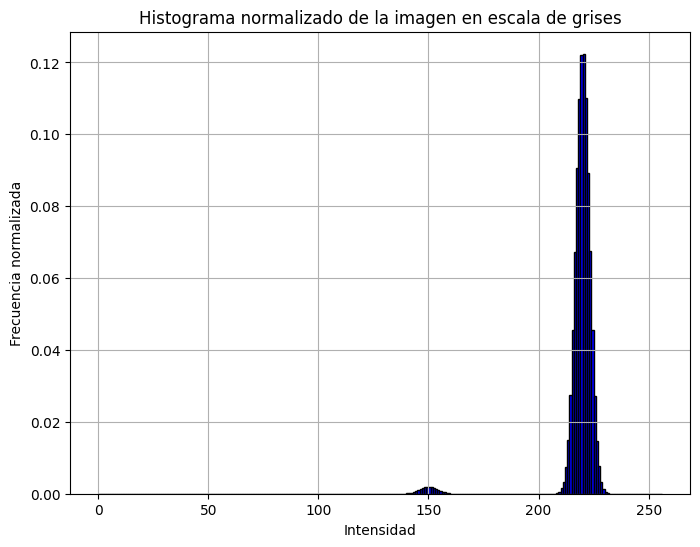

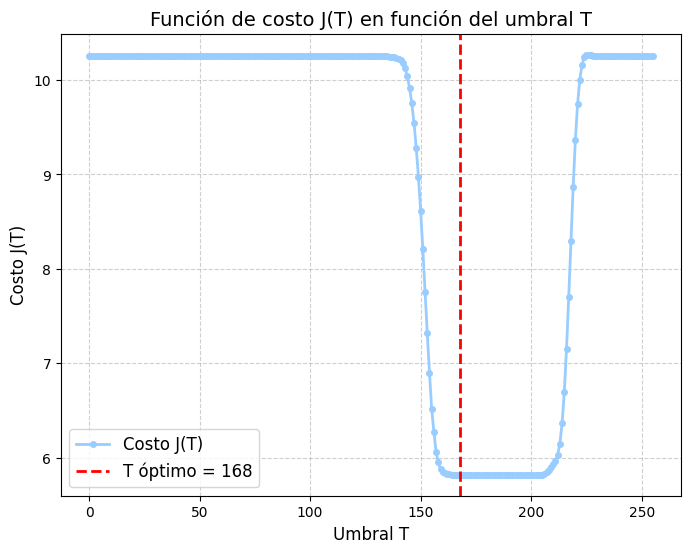

Umbral óptimo τ: 168
Para fondo: μ₁ = 149.45, σ₁² = 15.37
Para objeto: μ₂ = 219.49, σ₂² = 10.05


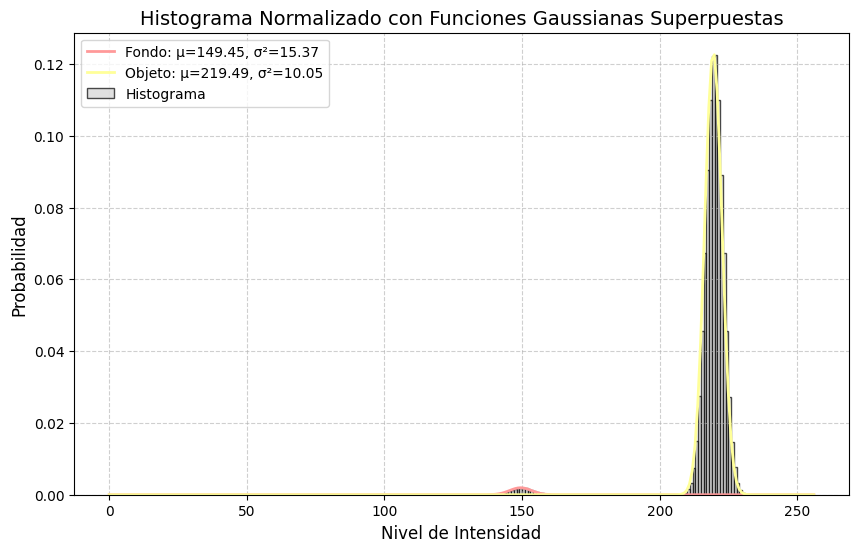

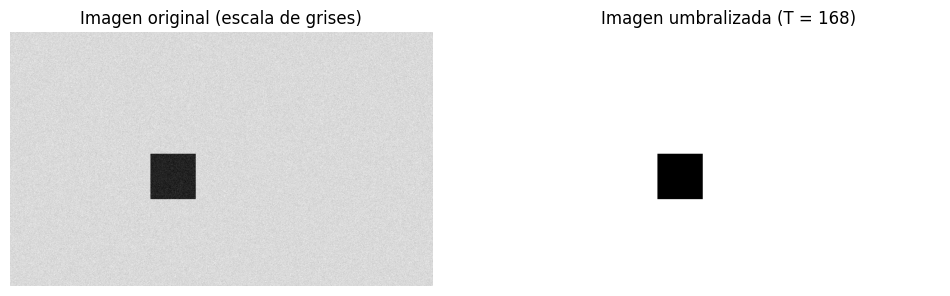

In [ ]:
T_optimo, imagen_umbralizada = calcular_T_optimo_Kittler(charge_image(cuadro1_005))

### e.

#### e.1.

Carga del Audio y Análisis del Histograma

En esta sección se realiza lo siguiente:
- Se carga el archivo `contaminated_audio.wav` utilizando `scipy.io.wavfile.read`.
- Si el audio es estéreo, se convierte a mono promediando los canales.
- Se calcula la magnitud absoluta de la señal y se normaliza al rango [0, 255] para trabajar con una escala similar a la de imágenes.
- Se convierte la señal normalizada a un tensor de PyTorch.
- Se calcula y grafica el histograma normalizado de la amplitud, lo que permite observar la distribución de la señal.
  
*Nota:* Debido a que el algoritmo de Kittler fue diseñado para datos con distribuciones gaussianas, su aplicación en audio (donde la señal de voz y silencio pueden no seguir estrictamente una distribución normal) puede tener limitaciones. Sin embargo, este método puede proporcionar una primera aproximación para la detección de actividad de voz.


In [ ]:
# =============================================================================
# Función 1: Procesamiento del Audio
# =============================================================================
def procesar_audio(audio_path: str) -> tuple:
    """
    Carga y preprocesa un archivo de audio para su análisis.

    Pasos:
      1. Carga el audio usando scipy.io.wavfile.read.
      2. Si el audio es estéreo, lo convierte a mono promediando los canales.
      3. Calcula la magnitud absoluta de la señal y la normaliza al rango [0, 255].
      4. Convierte la señal normalizada a un tensor de PyTorch.
      5. Calcula el histograma normalizado de la señal utilizando la función
         calcular_histograma_normalizado.

    Parámetros:
      audio_path : str
          Ruta del archivo de audio.

    Retorna:
      tuple: (fs, audio_tensor, hist_audio, bin_edges)
          fs           : Frecuencia de muestreo.
          audio_tensor : Tensor del audio normalizado.
          hist_audio   : Histograma normalizado de la señal.
          bin_edges    : Bordes de los bins usados para el histograma.
    """
    fs, audio = wavfile.read(audio_path)
    # Si el audio es estéreo, convertirlo a mono.
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    # Calcular la magnitud y normalizar al rango [0, 255].
    audio_abs = np.abs(audio.astype(np.float32))
    audio_norm = (audio_abs / np.max(audio_abs)) * 255
    # Convertir la señal normalizada a tensor de PyTorch.
    audio_tensor = torch.tensor(audio_norm, dtype=torch.float32)
    # Calcular el histograma normalizado usando la función previamente definida.
    hist_audio, bin_edges = calcular_histograma_normalizado(audio_tensor, num_bins=256)
    return fs, audio_tensor, hist_audio, bin_edges


In [ ]:
# =============================================================================
# Función 2: Mostrar el Histograma del Audio
# =============================================================================
def mostrar_histograma_audio(hist_audio: torch.Tensor, bin_edges: np.ndarray) -> None:
    """
    Grafica el histograma normalizado de la señal de audio.

    Utiliza la función graficar_histograma_normalizado para visualizar el histograma.

    Parámetros:
      hist_audio : torch.Tensor
          Histograma normalizado del audio.
      bin_edges  : np.ndarray
          Bordes de los bins.

    Retorna:
      None. Muestra la gráfica.
    """
    graficar_histograma_normalizado(hist_audio, bin_edges)


#### e.2.

Gráfico de la Función de Costo \( J(T) \) y Superposición de Gaussianas

En esta sección se realizan los siguientes pasos:
- Se evalúa la función de costo \( J(T) \) para cada umbral candidato (T entre 0 y 254) utilizando la función `funcion_costo_kittler` aplicada al histograma del audio.
- Se grafica \( J(T) \) y se marca el umbral óptimo \( \tau \) (donde \( J(T) \) es mínimo).
- Se calculan los momentos estadísticos en \( \tau \) (pesos, medias y varianzas) mediante la función `calcular_momentos_estadisticos`.
- Se superponen sobre el histograma las funciones gaussianas correspondientes a los dos grupos (por ejemplo, silencio y voz) utilizando los parámetros obtenidos.
- Se documenta el valor \( \tau \) junto con las medias y varianzas, y se discute si estos valores son coherentes con la forma del histograma.


In [ ]:
# =============================================================================
# Función 3: Evaluar la Función de Costo J(T) en el Audio
# =============================================================================
def evaluar_costo_audio(hist_audio: torch.Tensor) -> tuple:
    """
    Evalúa la función de costo J(T) para cada umbral T (0 a 255) a partir del histograma del audio.

    Se utiliza la función calcular_costo_J para calcular el costo para cada T, se grafica la función J(T)
    y se determina el umbral óptimo (τ) que minimiza dicho costo.

    Parámetros:
      hist_audio : torch.Tensor
          Histograma normalizado del audio.

    Retorna:
      tuple: (tau, costos)
          tau    : Umbral óptimo obtenido.
          costos : Lista de costos J(T) evaluados.
    """
    costos = [calcular_costo_J(T, hist_audio) for T in range(256)]
    # Graficar la función J(T) usando la función ya definida.
    graficar_funcion_J(torch.tensor(costos), num_bins=256)
    costos_np = np.array(costos)
    tau = int(np.argmin(costos_np))
    return tau, costos


In [ ]:
# =============================================================================
# Función 4: Mostrar Gaussianas Superpuestas al Histograma del Audio
# =============================================================================
def mostrar_gaussianas_audio(hist_audio: torch.Tensor, bin_edges: np.ndarray, tau: int) -> dict:
    """
    Calcula los momentos estadísticos en el umbral óptimo τ y grafica el histograma del audio
    con las funciones gaussianas superpuestas.

    Se obtienen los parámetros (ω, μ y σ²) mediante calcular_momentos_estadisticos, se crea un
    diccionario para las dos clases (silencio y voz) y se superponen las curvas gaussianas al histograma.

    Parámetros:
      hist_audio : torch.Tensor
          Histograma normalizado del audio.
      bin_edges  : np.ndarray
          Bordes de los bins.
      tau        : int
          Umbral óptimo obtenido.

    Retorna:
      dict: Los momentos estadísticos calculados.
    """
    momentos = calcular_momentos_estadisticos(tau, hist_audio)
    gaussianas = [
        {"omega": momentos['omega0'], "mu": momentos['mu0'], "sigma": momentos['sigma0'], "label": "Silencio"},
        {"omega": momentos['omega1'], "mu": momentos['mu1'], "sigma": momentos['sigma1'], "label": "Voz"}
    ]
    graficar_histograma_gaussianas(hist_audio, bin_edges, gaussianas)
    print(f"Umbral óptimo τ: {tau}")
    print(f"Silencio: μ = {momentos['mu0']:.2f}, σ² = {momentos['sigma0']:.2f}")
    print(f"Voz: μ = {momentos['mu1']:.2f}, σ² = {momentos['sigma1']:.2f}")
    return momentos


#### e.3.

Umbralización y Segmentación del Audio

En esta sección se procede a:
- Umbralizar el audio usando el umbral óptimo \( \tau \) obtenido previamente, clasificando cada muestra en "voz" (si la amplitud normalizada es mayor que \( \tau \)) o "silencio".
- Detectar los cambios de estado (de voz a silencio y viceversa) para segmentar el audio en regiones continuas.
- Se espera obtener tres segmentos: dos correspondientes a actividad de voz (segmentos de voz) y uno a falta de actividad (segmento de silencio) entre ellos.
- Se muestra la señal original junto con las áreas clasificadas para una visualización clara de la segmentación.


In [ ]:
# =============================================================================
# Función 5: Segmentación y Umbralización del Audio
# =============================================================================
def segmentar_audio(audio_tensor: torch.Tensor, tau: int, fs: int) -> None:
    """
    Umbraliza y segmenta la señal de audio usando el umbral óptimo τ.

    Se clasifica cada muestra como "voz" (si la amplitud > τ) o "silencio" (si ≤ τ), se detectan los
    cambios de estado para segmentar la señal, se imprimen los segmentos y se grafica la señal con
    áreas coloreadas que indican voz y silencio.

    Parámetros:
      audio_tensor : torch.Tensor
          Señal de audio normalizada.
      tau          : int
          Umbral óptimo obtenido.
      fs           : int
          Frecuencia de muestreo del audio.

    Retorna:
      None. Muestra la gráfica y la información de segmentación.
    """
    # Umbralizar el audio: 1 para voz, 0 para silencio.
    etiquetas = (audio_tensor > tau).numpy().astype(np.uint8)
    # Detectar cambios de estado.
    cambios = np.where(np.diff(etiquetas) != 0)[0] + 1
    segmentos = []
    inicio = 0
    for cambio in cambios:
        segmentos.append((inicio, cambio))
        inicio = cambio
    segmentos.append((inicio, len(etiquetas)))

    # Clasificar segmentos.
    segmentos_voz = [seg for seg in segmentos if etiquetas[seg[0]] == 1]
    segmentos_silencio = [seg for seg in segmentos if etiquetas[seg[0]] == 0]

    print("Segmentos de voz detectados:")
    for seg in segmentos_voz:
        print(f"Inicio: {seg[0]}, Fin: {seg[1]}, Duración: {seg[1]-seg[0]} muestras")
    print("Segmentos de silencio detectados:")
    for seg in segmentos_silencio:
        print(f"Inicio: {seg[0]}, Fin: {seg[1]}, Duración: {seg[1]-seg[0]} muestras")

    # Visualización de la señal segmentada.
    plt.figure(figsize=(12, 4))
    tiempo = np.arange(len(audio_tensor)) / fs
    plt.plot(tiempo, audio_tensor.numpy(), color='gray', lw=0.8, label="Amplitud Normalizada")
    plt.fill_between(tiempo, 0, audio_tensor.numpy(), where=(etiquetas==1), color='red', alpha=0.4, label="Voz")
    plt.fill_between(tiempo, 0, audio_tensor.numpy(), where=(etiquetas==0), color='blue', alpha=0.3, label="Silencio")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud Normalizada")
    plt.title(f"Segmentación del Audio usando τ = {tau}")
    plt.legend()
    plt.show()


In [ ]:
# =============================================================================
# Función Principal: Procesar y Segmentar Audio
# =============================================================================
def procesar_audio_y_segmentar(audio_path: str) -> None:
    """
    Integra todo el flujo de procesamiento del audio para detectar actividad de voz.

    Pasos:
      1. Carga y preprocesa el audio.
      2. Calcula y grafica el histograma normalizado del audio.
      3. Evalúa la función de costo J(T) y determina el umbral óptimo τ.
      4. Calcula y grafica las funciones gaussianas superpuestas al histograma.
      5. Umbraliza y segmenta el audio, mostrando los segmentos de voz y silencio.

    Parámetros:
      audio_path : str
          Ruta del archivo de audio.

    Retorna:
      None. Ejecuta todo el proceso y muestra los resultados mediante gráficos e impresiones.
    """
    # Procesar el audio: carga, normalización y cálculo del histograma.
    fs, audio_tensor, hist_audio, bin_edges = procesar_audio(audio_path)

    # Graficar el histograma normalizado del audio.
    mostrar_histograma_audio(hist_audio, bin_edges)

    # Evaluar la función de costo y obtener el umbral óptimo τ.
    tau, _ = evaluar_costo_audio(hist_audio)

    # Calcular momentos y graficar las curvas gaussianas sobre el histograma.
    mostrar_gaussianas_audio(hist_audio, bin_edges, tau)

    # Segmentación y umbralización del audio.
    segmentar_audio(audio_tensor, tau, fs)


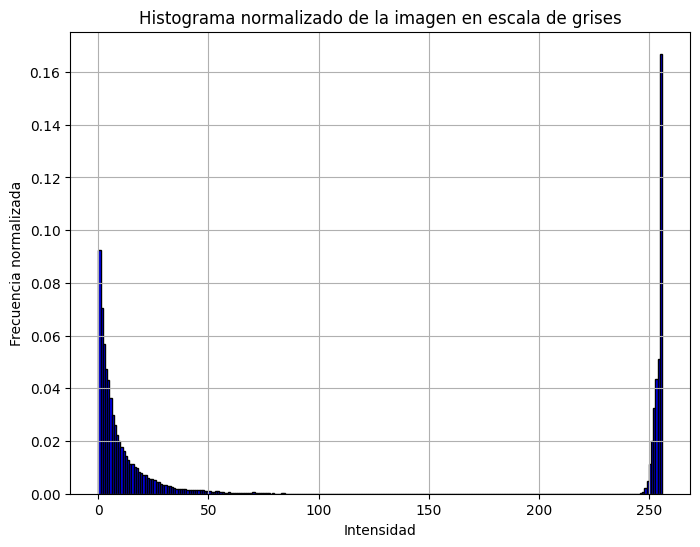

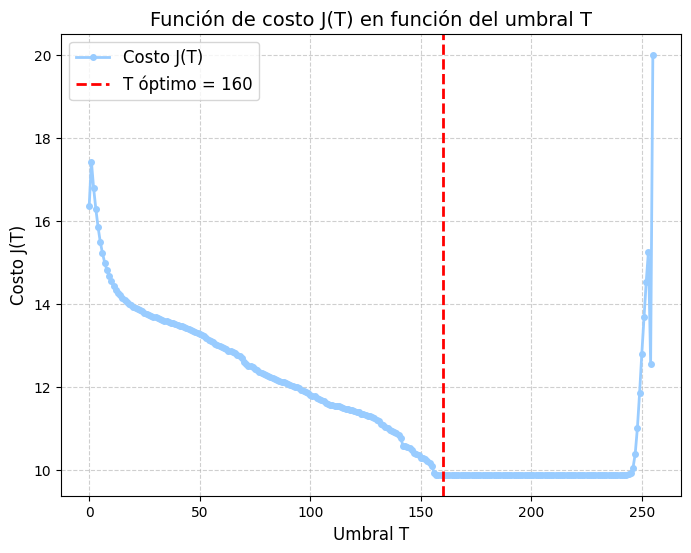

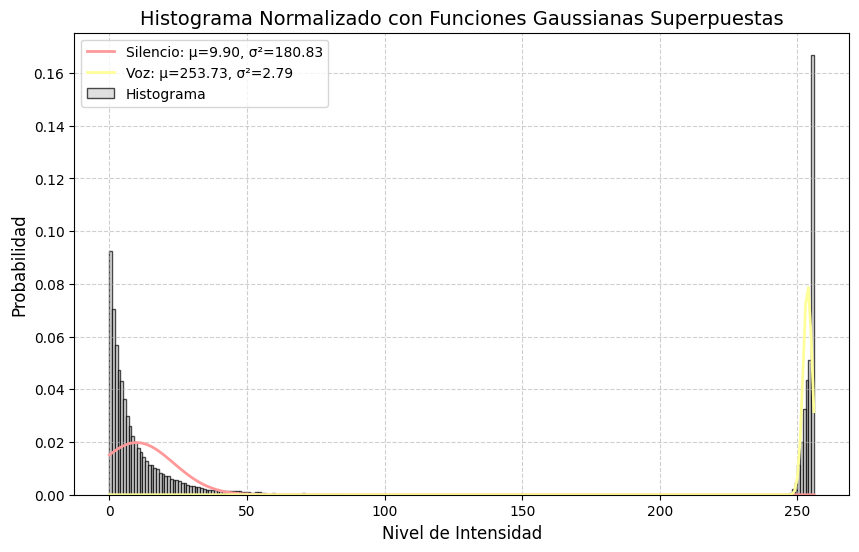

Umbral óptimo τ: 160
Silencio: μ = 9.90, σ² = 180.83
Voz: μ = 253.73, σ² = 2.79
Segmentos de voz detectados:
Inicio: 84046, Fin: 168092, Duración: 84046 muestras
Segmentos de silencio detectados:
Inicio: 0, Fin: 84046, Duración: 84046 muestras
Inicio: 168092, Fin: 252138, Duración: 84046 muestras


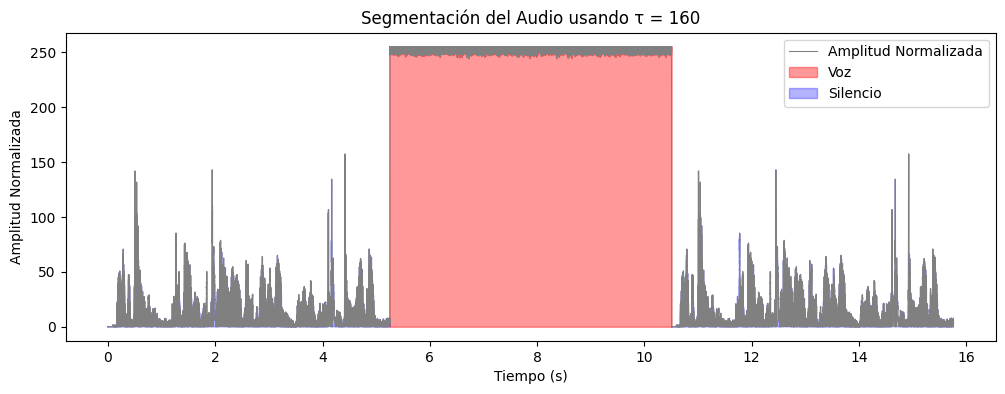

In [ ]:
# =============================================================================
# Llamada Final: Ejecuta Todo el Flujo de Procesamiento y Segmentación de Audio
# =============================================================================
procesar_audio_y_segmentar(contaminated_audio)

### Evaluación del algoritmo de Kittler para detección de actividad de voz

**1) ¿Es apropiado usar el algoritmo de Kittler para segmentar el audio?**

Al graficar el histograma del audio normalizado, se observa una distribución claramente bimodal: una acumulación de amplitudes muy bajas (correspondientes a silencio o ruido de fondo) y otra muy pronunciada cerca del máximo (actividad de voz). Esta forma sugiere que la señal puede ser modelada razonablemente como una mezcla de dos distribuciones gaussianas. Por tanto, el uso del algoritmo de Kittler, que asume dicha estructura, es una aproximación válida para este caso.

---

**2) Valor óptimo de \( \tau \), medias y varianzas de las gaussianas, y coherencia con el histograma**

La función de costo \( J(T) \) fue calculada para umbrales candidatos \( T \in [0, 254] \). El valor mínimo de la función se alcanza en:

\[
\tau = 160
\]

A este umbral le corresponden los siguientes parámetros estadísticos:

- **Silencio**: \( \mu = 9.90 \), \( \sigma^2 = 180.83 \)
- **Voz**: \( \mu = 253.73 \), \( \sigma^2 = 2.79 \)

Las dos gaussianas obtenidas se superponen sobre el histograma original y muestran una buena correspondencia visual con los picos observados en los extremos de la distribución. Esto confirma la validez del modelo estimado mediante máxima verosimilitud.

---

**3) Segmentación del audio usando \( \tau \)**

Se umbralizó el audio utilizando \( \tau = 160 \), clasificando cada muestra como "voz" si su amplitud normalizada era mayor que el umbral, y "silencio" en caso contrario. Luego, se detectaron los cambios de estado para identificar segmentos contiguos. El resultado fue el siguiente:

- Segmento de **silencio**: desde 0 hasta 84046 muestras
- Segmento de **voz**: desde 84046 hasta 168092 muestras
- Segmento de **silencio**: desde 168092 hasta 252138 muestras

La visualización de la señal junto con las regiones clasificadas evidencia una segmentación limpia en tres bloques: dos de voz y uno de silencio entre ellos, tal como se esperaba. Esto demuestra que el algoritmo de Kittler logró una segmentación satisfactoria del audio.

---


## 2.

**Distancia de Bhattacharyya**

La **distancia de Bhattacharyya** es una medida estadística que cuantifica la similitud (o, de manera inversa, la disimilitud) entre dos funciones de densidad de probabilidad. A continuación se detalla qué es, para qué sirve y cómo se calcula.

---
**¿Qué es la distancia de Bhattacharyya?**

- **Definición:**  
  Es una métrica que evalúa la superposición entre dos distribuciones de probabilidad, midiendo el grado de coincidencia entre ellas.

- **Interpretación:**  
  - Un valor **bajo** de la distancia indica que las distribuciones tienen una gran superposición, es decir, son muy similares.  
  - Un valor **alto** indica que las distribuciones están más separadas y tienen poca superposición.

---
**¿Para qué sirve?**

- **Reconocimiento de patrones y clasificación:**  
  Se utiliza para comparar modelos o muestras en tareas de clasificación y reconocimiento de objetos. Por ejemplo, en visión por computadora, ayuda a evaluar qué tan bien se ajusta un modelo (como uno gaussiano) a los datos observados.

- **Validación de modelos:**  
  En el contexto del algoritmo de Kittler, se usa para comparar la densidad de probabilidad estimada a partir de un modelo mixto gaussiano (p(x)) con la densidad empírica derivada del histograma de datos (q(x)). Una menor distancia indica un mejor ajuste entre el modelo y los datos reales.

- **Procesamiento de señales:**  
  Se aplica en áreas como procesamiento de señales y bioinformática para comparar distribuciones y validar modelos estadísticos.

---
**¿Cómo se calcula?**

La fórmula para la distancia de Bhattacharyya es:

$$
D_B(p, q) = -\ln\left( \sum_{x \in X} \sqrt{p(x) \cdot q(x)} \right)
$$

donde:
- \( p(x) \) y \( q(x) \) son las funciones de densidad de probabilidad de las distribuciones a comparar.
- La suma se realiza sobre el dominio \( X \) de las variables.
- En la práctica, se suele incluir un pequeño valor \( \varepsilon \) para evitar problemas con el logaritmo de cero:

$$
D_B(p, q) = -\ln\left( \sum_{x \in X} \sqrt{p(x) \cdot q(x) + \varepsilon} \right)
$$

**Pasos para calcularla:**

1. **Normalización:**  
   Asegurarse de que ambas distribuciones estén normalizadas (la suma o integral de las probabilidades debe ser 1).

2. **Producto raíz:**  
   Para cada valor \( x \) en el dominio, calcular $\sqrt{p(x) \cdot q(x)}$ .

3. **Suma:**  
   Sumar todos los valores obtenidos en el paso anterior.

4. **Logaritmo negativo:**  
   Aplicar el logaritmo natural al resultado de la suma y multiplicar por -1 para obtener la distancia.

---
**Ejemplo Conceptual**

Si las dos distribuciones son muy similares, la suma $\sum_{x \in X} \sqrt{p(x) \cdot q(x)}$ será cercana a 1, lo que producirá una distancia baja. Por el contrario, si las distribuciones son muy diferentes, la suma será menor y la distancia de Bhattacharyya será mayor.

### a.

In [ ]:
def calcular_bhattacharyya_distance(p: np.ndarray, q: np.ndarray, epsilon: float = 1e-12) -> float:
    """
    Calcula la distancia de Bhattacharyya entre dos distribuciones de probabilidad p y q.

    La fórmula utilizada es:

    $$
    D_B(p, q) = -\ln\left(\sum_{x \in X} \sqrt{p(x) \cdot q(x)}\right)
    $$

    Donde:
      - \( p(x) \) y \( q(x) \) son las funciones de densidad de probabilidad, las cuales deben estar normalizadas (la suma total es 1).
      - Se utiliza un valor pequeño \( \varepsilon \) para evitar problemas numéricos en caso de que el coeficiente de Bhattacharyya sea 0.

    Pasos:
      1. Se convierten las entradas p y q a arrays de tipo float64.
      2. Se calcula el coeficiente de Bhattacharyya como la suma de la raíz cuadrada del producto elemento a elemento:
         \( \text{BC} = \sum_{x \in X} \sqrt{p(x) \cdot q(x)} \).
      3. Se garantiza que el coeficiente sea al menos \( \varepsilon \) para evitar tomar el logaritmo de 0.
      4. Se calcula la distancia como el negativo del logaritmo natural del coeficiente.

    Parámetros:
    -----------
    p : np.ndarray
        Vector que representa la densidad de probabilidad p(x), normalizado (suma 1).
    q : np.ndarray
        Vector que representa la densidad de probabilidad q(x), normalizado (suma 1).
    epsilon : float, opcional
        Valor pequeño para evitar problemas al calcular el logaritmo de cero. Por defecto es 1e-12.

    Retorna:
    --------
    float
        La distancia de Bhattacharyya entre las distribuciones p y q.
    """
    # Asegurarse de que p y q sean arrays de NumPy de tipo float64
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)

    # Calcular el coeficiente de Bhattacharyya
    bc_coeff = np.sum(np.sqrt(p * q))

    # Evitar log(0): si el coeficiente es menor que epsilon, usar epsilon.
    bc_coeff = max(bc_coeff, epsilon)

    # Calcular la distancia como el negativo del logaritmo natural del coeficiente
    distance = -np.log(bc_coeff)
    return distance


### b.


In [ ]:
def comparar_histograma_vs_modelo_imagen(hist: torch.Tensor, moments: dict, num_bins: int = 256) -> float:
    """
    Compara el histograma real de la imagen (p(x)) con la función de densidad estimada (q(x))
    derivada de un modelo mixto gaussiano (Kittler), y calcula la distancia de Bhattacharyya entre ellas.

    La función realiza los siguientes pasos:
      1. Extrae los parámetros (ω, μ y σ²) de los dos grupos (fondo y objeto) del diccionario `moments`.
      2. Calcula las desviaciones estándar a partir de las varianzas.
      3. Construye la función de densidad estimada q(x) como una mezcla de dos Gaussianas:
             q(x) = ω₀ * N(x; μ₀, σ₀) + ω₁ * N(x; μ₁, σ₁),
         donde N(x; μ, σ) es la densidad gaussiana con media μ y desviación estándar σ.
      4. Normaliza q(x) para que la suma de sus valores sea 1.
      5. Calcula la distancia de Bhattacharyya entre el histograma real p(x) y q(x) utilizando la función
         calcular_bhattacharyya_distance.
      6. Grafica ambas distribuciones para comparación visual.

    Parámetros:
    -----------
    hist : torch.Tensor
        Histograma normalizado de la imagen (p(x)).
    moments : dict
        Diccionario obtenido de calcular_momentos_estadisticos que contiene:
          - 'omega0', 'omega1': Pesos de fondo y objeto.
          - 'mu0', 'mu1': Medias de fondo y objeto.
          - 'sigma0', 'sigma1': Varianzas de fondo y objeto.
    num_bins : int, opcional
        Número de niveles de intensidad a evaluar (por defecto 256).

    Retorna:
    --------
    float
        La distancia de Bhattacharyya entre el histograma real p(x) y el modelo gaussiano q(x).
    """
    # Función auxiliar para calcular la densidad gaussiana.
    def gaussian_pdf(x, mu, sigma):
        return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    # Extraer parámetros del modelo
    omega0 = moments['omega0']
    omega1 = moments['omega1']
    mu0 = moments['mu0']
    mu1 = moments['mu1']
    varianza0 = moments['sigma0']  # Varianza del grupo fondo
    varianza1 = moments['sigma1']  # Varianza del grupo objeto

    # Calcular las desviaciones estándar a partir de las varianzas.
    sigma0 = np.sqrt(varianza0)
    sigma1 = np.sqrt(varianza1)

    # Generar el eje de intensidades: de 0 a num_bins-1.
    x_range = np.linspace(0, num_bins - 1, num_bins)

    # Calcular la función de densidad estimada q(x) como la suma de dos Gaussianas:
    q_imagen = (omega0 * gaussian_pdf(x_range, mu0, sigma0) +
                omega1 * gaussian_pdf(x_range, mu1, sigma1))

    # Normalizar q(x) para que la suma total sea 1.
    q_imagen /= (np.sum(q_imagen) + 1e-12)

    # Convertir el histograma real a array de NumPy, si es tensor.
    p_imagen = hist.numpy() if isinstance(hist, torch.Tensor) else hist

    # Calcular la distancia de Bhattacharyya utilizando la función previamente definida.
    distancia = calcular_bhattacharyya_distance(p_imagen, q_imagen)
    print("Distancia de Bhattacharyya (Imagen):", distancia)

    # Graficar las dos distribuciones para comparación visual.
    plt.figure(figsize=(8, 5))
    plt.bar(x_range, p_imagen, color='gray', width=1.0, alpha=0.6, label="Histograma (p)")
    plt.plot(x_range, q_imagen, color='red', lw=2, label="Modelo Gaussiano (q)")
    plt.title("Comparación: Histograma vs. Modelo Gaussiano (Imagen)")
    plt.xlabel("Nivel de Intensidad")
    plt.ylabel("Probabilidad")
    plt.legend()
    plt.show()

    return distancia


Distancia de Bhattacharyya (Imagen): 2.403232059367945e-05


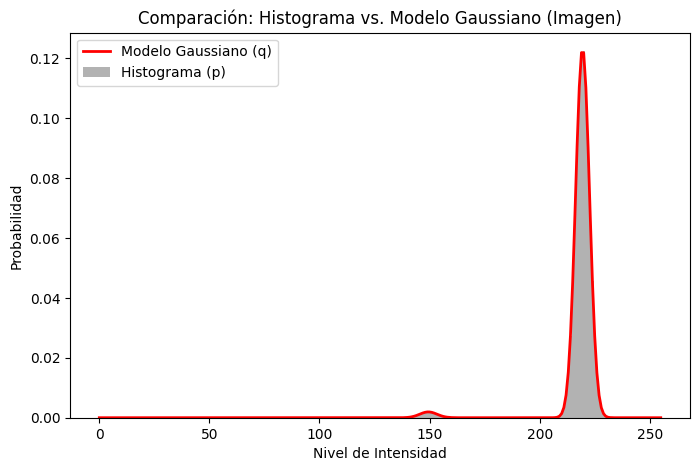

Distancia de Bhattacharyya entre el histograma y el modelo: 2.403232059367945e-05


In [ ]:
# Llamada final para el ejercicio: Comparación de Histograma vs. Modelo Gaussiano en Imagen

# 1. Cargar la imagen
imagen_tensor = charge_image(cuadro1_005)

# 2. Calcular el histograma normalizado de la imagen y obtener los bordes de los bins.
hist, bin_edges = calcular_histograma_normalizado(imagen_tensor, num_bins=256)

# 3. Calcular la función de costo J(T) para cada T y determinar el umbral óptimo.
#    Se evalúa el costo para cada umbral T (0 a 255) usando la función calcular_costo_J.
costos = [calcular_costo_J(T, hist) for T in range(256)]
costos_np = np.array(costos)
T_optimo = int(np.argmin(costos_np))

# 4. Obtener los momentos estadísticos para el umbral óptimo.
moments = calcular_momentos_estadisticos(T_optimo, hist)

# 5. Llamar a la función comparar_histograma_vs_modelo_imagen para graficar la comparación y obtener la distancia de Bhattacharyya.
distancia = comparar_histograma_vs_modelo_imagen(hist, moments, num_bins=256)
print("Distancia de Bhattacharyya entre el histograma y el modelo:", distancia)


**Comparación en el Audio: Histograma vs. Modelo Gaussiano**

En esta sección se aplica un procedimiento similar al de la imagen, pero para el audio:
- Se utiliza el histograma normalizado del audio (previamente calculado) y los parámetros estimados por el algoritmo de Kittler (para las dos clases: por ejemplo, silencio y voz) para construir la densidad estimada \( q(x) \) como una mezcla de dos Gaussianas.
- Se normaliza la densidad \( q(x) \) y se calcula la distancia de Bhattacharyya entre \( p(x) \) (el histograma) y \( q(x) \) (el modelo).
- Se grafica la comparación para visualizar la aproximación del modelo a la distribución real del audio.

Esto permite evaluar la calidad del ajuste del modelo en el contexto del audio.

In [ ]:
def comparar_histograma_vs_modelo_audio(hist_audio: torch.Tensor, momentos: dict, num_bins: int = 256) -> float:
    """
    Compara el histograma real del audio (p(x)) con un modelo gaussiano mixto q(x) estimado a partir
    de los parámetros obtenidos (momentos). Esta función construye q(x) como una mezcla de dos Gaussianas
    (una para "silencio" y otra para "voz"), normaliza q(x), calcula la distancia de Bhattacharyya entre
    p(x) y q(x), y grafica ambas distribuciones para una comparación visual.

    Pasos:
      1. Genera un vector de intensidades x_vals en el rango [0, num_bins-1].
      2. Extrae los parámetros del diccionario `momentos`:
         - ω₀ y ω₁: pesos (probabilidades) de cada clase.
         - μ₀ y μ₁: medias de cada clase.
         - σ₀ y σ₁: varianzas de cada clase (se calculará la desviación estándar como raíz cuadrada).
      3. Para cada valor x en x_vals, calcula la densidad gaussiana para cada clase utilizando la función
         auxiliar `gaussian_pdf` y suma ambas contribuciones para formar q(x).
      4. Normaliza q(x) para que su suma sea 1.
      5. Convierte el histograma real p(x) (hist_audio) a un array NumPy (si no lo es ya).
      6. Calcula la distancia de Bhattacharyya entre p(x) y q(x) mediante la función
         `calcular_bhattacharyya_distance`.
      7. Grafica p(x) y q(x) para facilitar la comparación visual.

    Parámetros:
      hist_audio : torch.Tensor
          Histograma normalizado del audio, que representa la densidad p(x).
      momentos : dict
          Diccionario con los momentos estadísticos del audio, con las siguientes claves:
            - 'omega0': Peso del segmento de silencio.
            - 'omega1': Peso del segmento de voz.
            - 'mu0': Media del segmento de silencio.
            - 'mu1': Media del segmento de voz.
            - 'sigma0': Varianza del segmento de silencio.
            - 'sigma1': Varianza del segmento de voz.
      num_bins : int, opcional
          Número de niveles de intensidad, por defecto 256.

    Retorna:
      float:
          La distancia de Bhattacharyya entre el histograma real p(x) y el modelo gaussiano q(x).
    """
    # Función auxiliar para calcular la densidad gaussiana.
    def gaussian_pdf(x, mu, sigma):
        return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    # Generar el vector de intensidades: de 0 a num_bins-1.
    x_vals = np.arange(num_bins)

    # Inicializar el vector q(x) para el modelo mixto gaussiano.
    q_audio = np.zeros_like(x_vals, dtype=np.float64)

    # Extraer parámetros de los momentos.
    omega0 = momentos['omega0']
    omega1 = momentos['omega1']
    mu0 = momentos['mu0']
    mu1 = momentos['mu1']
    # sigma0 y sigma1 son varianzas; se calcula la desviación estándar.
    sigma0 = np.sqrt(momentos['sigma0'])
    sigma1 = np.sqrt(momentos['sigma1'])

    # Construir q(x) como la suma de las dos densidades gaussianas ponderadas.
    for i, x in enumerate(x_vals):
        densidad_silencio = omega0 * gaussian_pdf(x, mu0, sigma0)
        densidad_voz = omega1 * gaussian_pdf(x, mu1, sigma1)
        q_audio[i] = densidad_silencio + densidad_voz

    # Normalizar q(x) para que la suma total sea 1.
    q_audio /= (np.sum(q_audio) + 1e-12)

    # Convertir el histograma real p(x) a un array NumPy, en caso de que sea tensor.
    p_audio = hist_audio.numpy() if isinstance(hist_audio, torch.Tensor) else hist_audio

    # Calcular la distancia de Bhattacharyya entre p(x) y q(x).
    distancia = calcular_bhattacharyya_distance(p_audio, q_audio)
    print("Distancia de Bhattacharyya (Audio):", distancia)

    # Graficar ambas distribuciones para comparación visual.
    plt.figure(figsize=(8, 5))
    plt.bar(x_vals, p_audio, color='gray', width=1.0, alpha=0.5, label="Histograma (p)")
    plt.plot(x_vals, q_audio, color='red', lw=2, label="Modelo Gaussiano (q)")
    plt.title("Comparación: Histograma vs. Modelo Gaussiano (Audio)")
    plt.xlabel("Nivel de Intensidad")
    plt.ylabel("Probabilidad")
    plt.legend()
    plt.show()

    return distancia


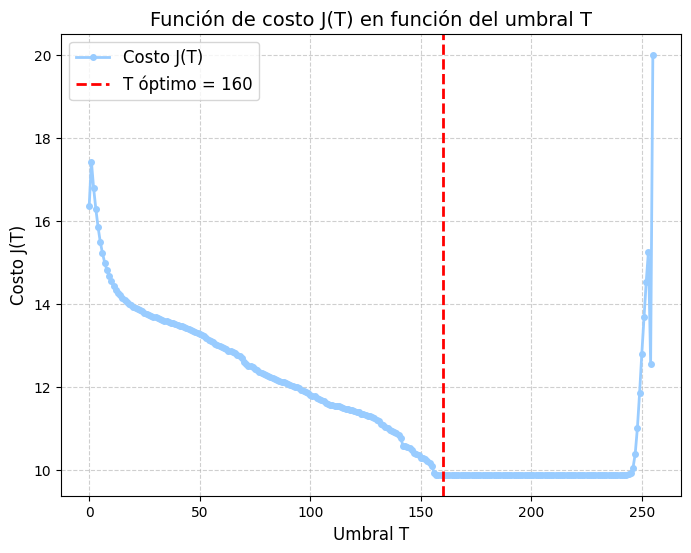

Distancia de Bhattacharyya (Audio): 0.08156438689128942


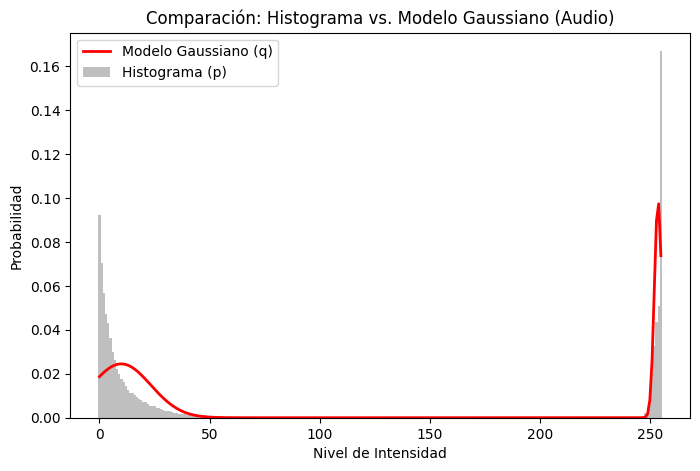

Distancia de Bhattacharyya para el audio: 0.08156438689128942


In [ ]:
# Llamada final para evaluar y comparar el modelo gaussiano vs. el histograma en el audio

# 1. Procesar el audio: cargar, normalizar y calcular el histograma normalizado.
fs, audio_tensor, hist_audio, bin_edges = procesar_audio(contaminated_audio)

# 2. Evaluar la función de costo J(T) para obtener el umbral óptimo (τ) a partir del histograma.
tau_audio, _ = evaluar_costo_audio(hist_audio)

# 3. Calcular los momentos estadísticos (pesos, medias y varianzas) en τ.
moments_audio = calcular_momentos_estadisticos(tau_audio, hist_audio)

# 4. Comparar el histograma real del audio con el modelo mixto gaussiano y calcular la distancia de Bhattacharyya.
distancia_audio = comparar_histograma_vs_modelo_audio(hist_audio, moments_audio, num_bins=256)
print("Distancia de Bhattacharyya para el audio:", distancia_audio)


## 3.


### a.

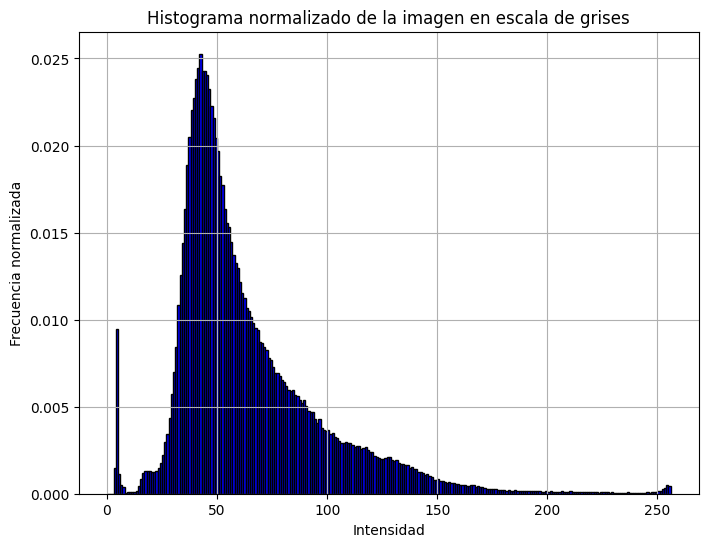

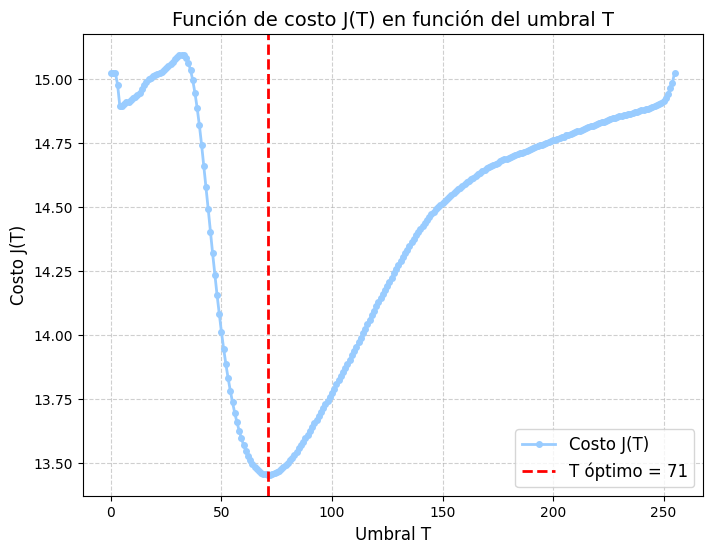

Umbral óptimo τ: 71
Para fondo: μ₁ = 46.45, σ₁² = 164.58
Para objeto: μ₂ = 104.95, σ₂² = 1004.44


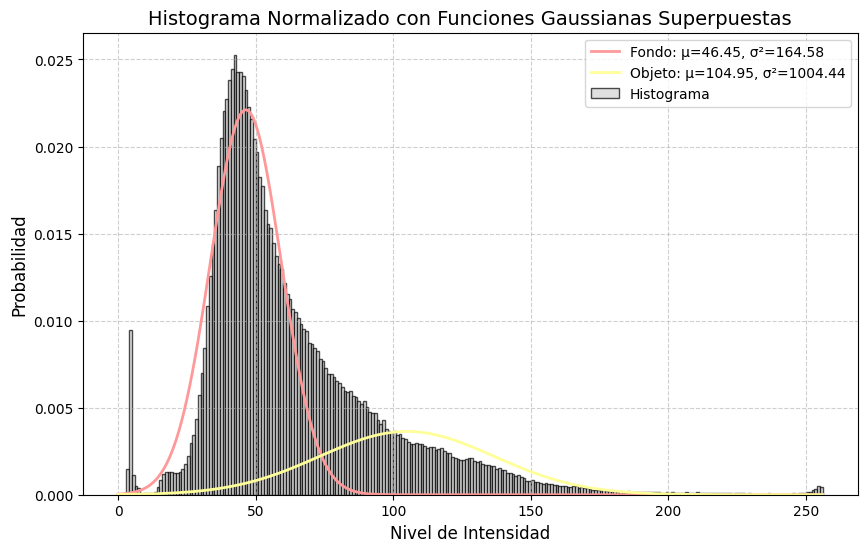

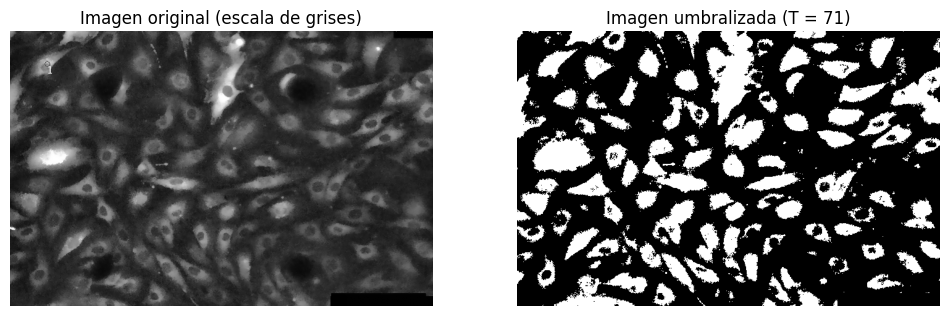

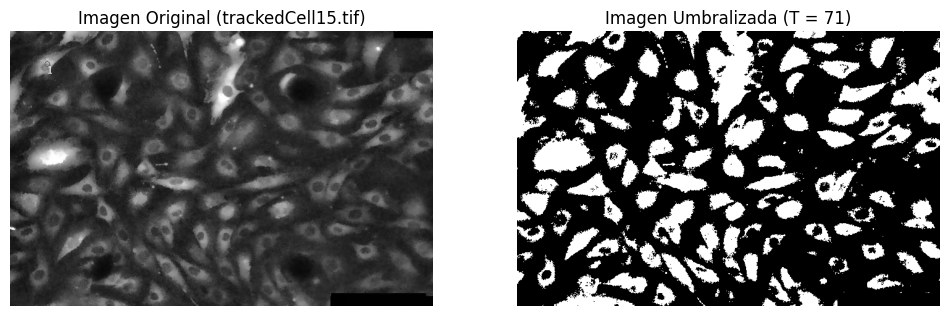

In [ ]:
# =============================================================================
# Umbralización de la imagen trackedCell15.tif
# =============================================================================
# Paso 1: Cargar la imagen trackedCell15.tif utilizando la función charge_image.
imagen_tracked = charge_image(trackedCell15)

# Paso 2: Calcular el umbral óptimo y la imagen umbralizada utilizando el algoritmo de Kittler.
T_optimo_tracked, imagen_umbralizada_tracked = calcular_T_optimo_Kittler(imagen_tracked)

# Paso 3: Mostrar la imagen original y la imagen umbralizada.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagen_tracked.numpy(), cmap='gray')
plt.title("Imagen Original (trackedCell15.tif)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_umbralizada_tracked.numpy(), cmap='gray')
plt.title(f"Imagen Umbralizada (T = {T_optimo_tracked})")
plt.axis('off')
plt.show()


**Análisis de Resultados - Umbralización de trackedCell15.tif con el Algoritmo de Kittler**

---
1. Histograma Normalizado de la Imagen

El histograma de la imagen muestra una distribución altamente asimétrica, con una concentración clara de intensidades en el rango bajo (alrededor de 40-60). Esta acumulación corresponde al fondo de la imagen (background), mientras que los valores de intensidad más dispersos hacia la derecha representan las regiones más brillantes, correspondientes a las células (foreground). La presencia de dos "modas" o agrupaciones sugiere que la segmentación binaria es razonable y viable.

---

2. Función de Costo \( J(T) \)

La curva de la función de costo \( J(T) \) muestra un comportamiento suave y bien definido, con un mínimo marcado en \( T = 71 \). Este umbral es el valor óptimo encontrado por el algoritmo de Kittler, y su ubicación coincide con el punto de transición entre los dos grupos dominantes de intensidades en el histograma. Esta concordancia valida la solidez del criterio de minimización de \( J(T) \), el cual penaliza las distribuciones con alta varianza o bajo peso de clase.

---

3. Modelo Mixto Gaussiano Superpuesto

La superposición de las dos gaussianas estimadas sobre el histograma muestra una aproximación razonable al comportamiento bimodal de los datos:

- **Fondo (clase 0):**  
  - Media: $ \mu_0 \approx 46.45 $  
  - Varianza: $ \sigma_0^2 \approx 164.58 $  
  - Se ajusta muy bien al pico dominante del histograma, modelando adecuadamente la región oscura del fondo.

- **Objeto (clase 1):**  
  - Media: $ \mu_1 \approx 104.95 $  
  - Varianza: $ \sigma_1^2 \approx 1004.44 $
  - Captura la cola derecha del histograma, representando las zonas brillantes de las células. La alta varianza indica una gran diversidad de intensidades dentro del objeto, lo cual es esperable en imágenes biológicas reales con estructuras complejas e iluminación variable.

El modelo se alinea visualmente de forma considerable con el histograma real, justificando el valor de umbral encontrado.

---

4. Imagen Umbralizada

La visualización de la imagen original y su correspondiente versión umbralizada revela una segmentación medianamente efectiva de las células:

- Las mayoría de las regiones celulares se destacan claramente del fondo, generando una máscara binaria bien definida.
- Aunque hay cierto ruido (pequeñas manchas aisladas en fondo y objeto), la mayor parte de las células están correctamente identificadas.
- La elección de \( T = 71 \) separa con una considerable tasa de exito las estructuras brillantes de interés (núcleos celulares) de la matriz de fondo oscuro.

---

5. Conclusión

El proceso completo, desde el cálculo del histograma hasta la estimación del modelo gaussiano y la umbralización binaria— ha producido un resultado coherente, interpretable y visualmente satisfactorio. El valor óptimo de umbral \( T = 71 \) logra una segmentación eficaz, justificando el uso del algoritmo de Kittler para este tipo de imágenes biomédicas.




### b.

**Posibles mejoras al algoritmo de Kittler**

Una posible mejora al algoritmo de Kittler consiste en aplicar técnicas de preprocesamiento que reduzcan el ruido en la imagen antes de calcular el histograma. En particular, el uso de filtros espaciales como el filtro mediano o gaussiano puede suavizar las pequeñas fluctuaciones de intensidad debidas al ruido de adquisición, generando así una distribución de intensidades más estable y representativa. Esto impacta directamente en la calidad del histograma y, en consecuencia, en la estabilidad del cálculo del umbral óptimo.

Además, el modelo original de Kittler asume que los datos provienen de una mezcla de dos distribuciones gaussianas, lo cual puede ser una limitación en imágenes reales como la de las células, donde las intensidades del foreground suelen presentar una dispersión elevada y comportamientos multimodales. En este sentido, se propone explorar modelos de mezcla más flexibles, como modelos no paramétricos, gaussian mixture models (GMM) con más de dos componentes, o incluso el uso de modelos con componentes no gaussianos como distribuciones Gamma o Rayleigh, que pueden capturar de forma más realista las colas largas o asimetrías presentes en los datos.

Desde el punto de vista de la optimización, el algoritmo podría beneficiarse de un esquema de validación cruzada o de ajuste iterativo guiado por métricas de evaluación de segmentación. Métricas como el índice de Jaccard, el coeficiente de Dice o la exactitud de clasificación binaria frente a máscaras manuales (ground truth) permitirían refinar el valor del umbral más allá del mínimo de la función de costo
𝐽
(
𝑇
)
, evaluando el desempeño práctico de la segmentación en términos de solapamiento con regiones relevantes. Asimismo, se podrían introducir penalizaciones adicionales en la función de costo que tengan en cuenta la compactación espacial o la continuidad estructural de las regiones segmentadas, lo cual sería particularmente útil en contextos biomédicos donde las estructuras de interés suelen tener formas bien definidas.

En conjunto, estas mejoras apuntan a aumentar la robustez del algoritmo y su capacidad de adaptación a distintos tipos de imágenes, especialmente aquellas con alta complejidad estructural o ruido significativo, como es el caso en aplicaciones de microscopía celular.

## 4.


Relación entre la Distancia de Bhattacharyya y el Algoritmo de Kittler

El algoritmo de Kittler (Minimum Error Thresholding) estima un umbral óptimo y los parámetros (pesos, medias y varianzas) de dos distribuciones gaussianas que se asumen modelan las dos clases presentes en los datos (por ejemplo, fondo y objeto en imágenes, o silencio y voz en audio).

La **distancia de Bhattacharyya** es una métrica que cuantifica la similitud entre dos distribuciones de probabilidad, \( p(x) \) y \( q(x) \). En este contexto:
- \( p(x) \) representa la distribución empírica de los datos, estimada a partir del histograma.
- \( q(x) \) es el modelo mixto gaussiano ajustado a partir de los parámetros obtenidos con Kittler.

**Interpretación:**
- Una **distancia pequeña** indica un gran solapamiento entre el modelo \( q(x) \) y la distribución empírica \( p(x) \), lo que sugiere que el modelo de dos Gaussianas se ajusta bien a los datos.
- Una **distancia grande** sugiere que el modelo no captura adecuadamente la distribución real, lo cual puede ocurrir si los datos tienen más de dos modos, ruidos o si la suposición de normalidad es inadecuada.

La distancia de Bhattacharyya sirve como un indicador adicional para evaluar la calidad del ajuste del modelo estimado mediante el algoritmo de Kittler.
